# Implementation of the Least Square Monte Carlo on American Put Options


In [5]:
import numpy as np
import pandas as pd
import American_Put_Close_Form as close_form

import Least_Square_Monte_Carlo as ls_monte_carlo
from tqdm import tqdm
from matplotlib import pyplot as plt

In [6]:
#------------------------------#

# call option parameters
rf = 0.05
vol = 0.25
n = 10000
s0 = 100
K = 100

horizon = 1
dtime = 0.01
N_steps = horizon/dtime

# additional parameters the for "close form" algorithm
dtime_CS = 0.01
times = np.arange(0,horizon+round(dtime_CS,3),dtime_CS).round(4)
#------------------------------#


### Least Square Monte Carlo Algorithm Peformance 
we benchmark the acurracy of the LS-MC algorithm against the iterative approach pricing approach, where we solve for exercise boundary at each time points. 

here we compared like for like with both algorithms at 100 exerciseible points, under the same strucutre.

In principle we observed that LS-MC is competitive both in accuracy as well as computational time (both within seconds). not shown here it is much more efficent computational wise than, "brute-force Monte Carlo" and have similar advantages

In [7]:
american_close_form = close_form.AmericanPut(rf, vol)
price_cs = american_close_form.price(s0,K,times)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:09<00:00, 10.14it/s]


In [8]:
american_lsm = ls_monte_carlo.American_Put_LSMC(0.01,1)
S_data = american_lsm.sample((rf-0.5*vol)*dtime,np.sqrt(vol*dtime),n,s0,True)
option_value, exercise = american_lsm.price(K,rf,4,0.5,S_data=S_data)
price_lsm = option_value[0].mean()
std_error = option_value[0].std()/np.sqrt(n)

In [9]:

print("Close form solution price        : {}".format(round(price_cs,5)))
print("Least Square Monte Carlo price   : {} ± {}".format(round(price_lsm,5),round(3*std_error,5)))


Close form solution price        : 17.45347
Least Square Monte Carlo price   : 17.15547 ± 0.49301


### Method sensitivity to hyperparameters
we see observed that the LS-MC method can be quite sensitive to hyperparameters choices, in our set up we have the lyperparameter $\alpha$ and $\lambda$. Lambda $\lambda$ stems from the Ridge Regresssion Loss function 

$$J = \sum_{i=1}^{n} (\lambda w_{i}^2 + (\hat{y}_{i}(x_{i})-y(i))^{2})$$

as well as the number of basis functions $\alpha$ where $L_{(i-1)}$ is the $i^{th}$ order Lagurre function as per suggested by original paper

$$\hat{y}_{i}(x_{i}) =\sum_{i=1}^{\alpha} L_{(i-1)}(x_i)$$

In [15]:
option_value1, exercise1 = american_lsm.price(K,rf,4,0,S_data=S_data)
mse1 = american_lsm.training_mse
mape1 = american_lsm.training_mape

option_value2, exercise2 = american_lsm.price(K,rf,4,0.5,S_data=S_data)
mse2 = american_lsm.training_mse
mape2 = american_lsm.training_mape

option_value3, exercise3 = american_lsm.price(K,rf,4,1,S_data=S_data)
mse3 = american_lsm.training_mse
mape3 = american_lsm.training_mape

option_value4, exercise4 = american_lsm.price(K,rf,5,0.5,S_data=S_data)
mse4 = american_lsm.training_mse
mape4 = american_lsm.training_mape

option_value5, exercise5 = american_lsm.price(K,rf,6,0.5,S_data=S_data)
mse5 = american_lsm.training_mse
mape5 = american_lsm.training_mape


p1 = option_value1[0].mean()
p2 = option_value2[0].mean()
p3 = option_value3[0].mean()
p4 = option_value4[0].mean()
p5 = option_value5[0].mean()


se1 = option_value1[0].std()/np.sqrt(n)
se2 = option_value2[0].std()/np.sqrt(n)
se3 = option_value3[0].std()/np.sqrt(n)
se4 = option_value4[0].std()/np.sqrt(n)
se5 = option_value5[0].std()/np.sqrt(n)

In [16]:
print("lambda = 0   price :{} ± {}".format(round(p1,5),round(3*se1,5)))
print("lambda = 0.5 price :{} ± {}".format(round(p2,5),round(3*se2,5)))
print("lambda = 1   price :{} ± {}".format(round(p3,5),round(3*se3,5)))

print("lambda = 0.5, 4th order Lagurre Polynomial price :{} ± {}".format(round(p2,5),round(3*se2,5)))
print("lambda = 0.5, 5th order Lagurre Polynomial price :{} ± {}".format(round(p4,5),round(3*se4,5)))
print("lambda = 0.5, 6th order Lagurre Polynomial price :{} ± {}".format(round(p5,5),round(3*se5,5)))


lambda = 0   price :17.14705 ± 0.49086
lambda = 0.5 price :17.15547 ± 0.49301
lambda = 1   price :17.18755 ± 0.49533
lambda = 0.5, 4th order Lagurre Polynomial price :17.15547 ± 0.49301
lambda = 0.5, 5th order Lagurre Polynomial price :16.03877 ± 0.44065
lambda = 0.5, 6th order Lagurre Polynomial price :14.85465 ± 0.38644


Here we see the mean under different choices of parameters, we see that the choce of these parameters can introduces systematic error into the accuracy of pring that would be hard to detect. 

this is expecially prominant in the choice of the total order of Lagurre Polynomials $\alpha$

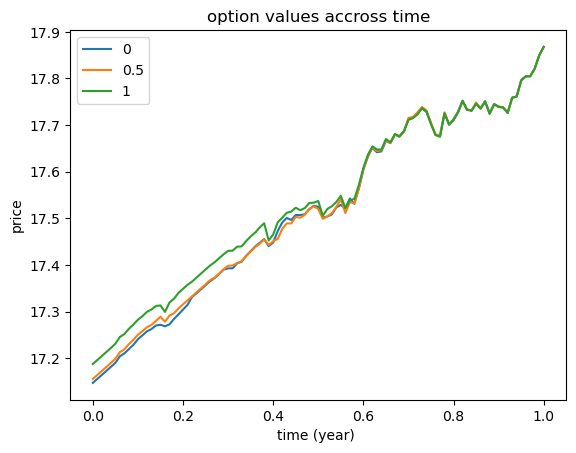

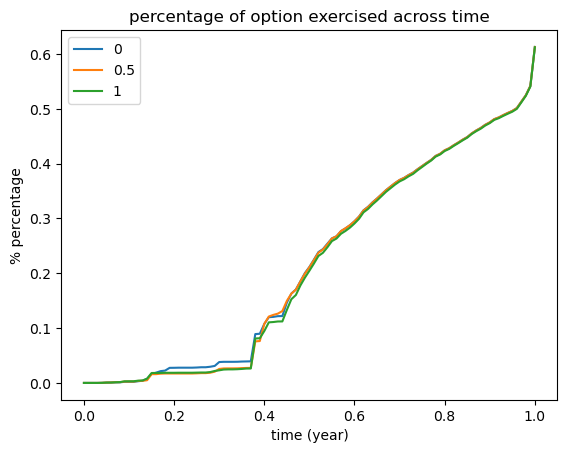

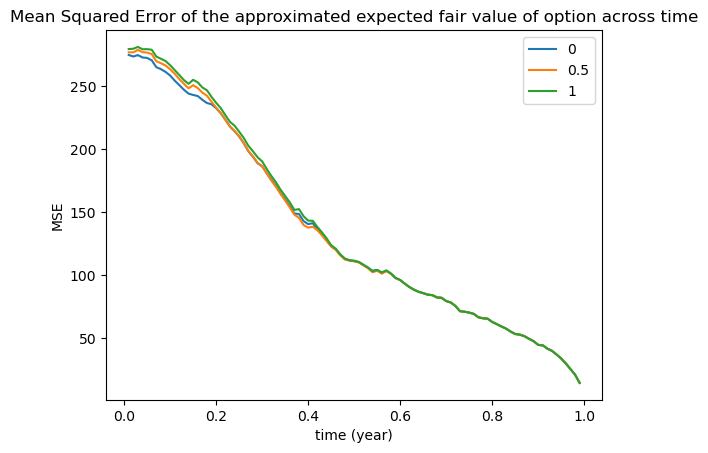

In [12]:
plt.figure(1)
plt.plot(times,option_value1.mean(1))
plt.plot(times,option_value2.mean(1))
plt.plot(times,option_value3.mean(1))
plt.legend(["0","0.5","1"])
plt.title("option values accross time")
plt.xlabel("time (year) ")
plt.ylabel("price")

plt.figure(2)
plt.plot(times,exercise1.sum(1).cumsum()/n)
plt.plot(times,exercise2.sum(1).cumsum()/n)
plt.plot(times,exercise3.sum(1).cumsum()/n)
plt.title("percentage of option exercised across time")
plt.xlabel("time (year)")
plt.ylabel("% percentage")
plt.legend(["0","0.5","1"])

plt.figure(3)
plt.plot(times,mse1)
plt.plot(times,mse2)
plt.plot(times,mse3)
plt.legend(["0","0.5","1"])
plt.title("Mean Squared Error of the approximated expected fair value of option across time")
plt.xlabel("time (year)")
plt.ylabel("MSE")
plt.legend(["0","0.5","1"])



Here we visualise the impact of choices of lambda, we see that the lack of the ridge term, creates "behaviorial" differences in it's decision to exercise, although this is not specifically reflected in the price of the option 

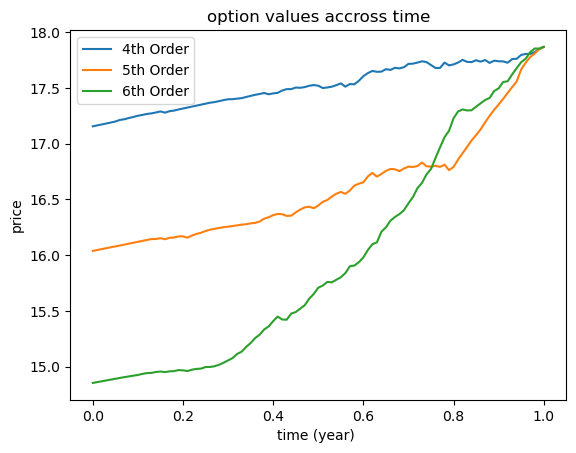

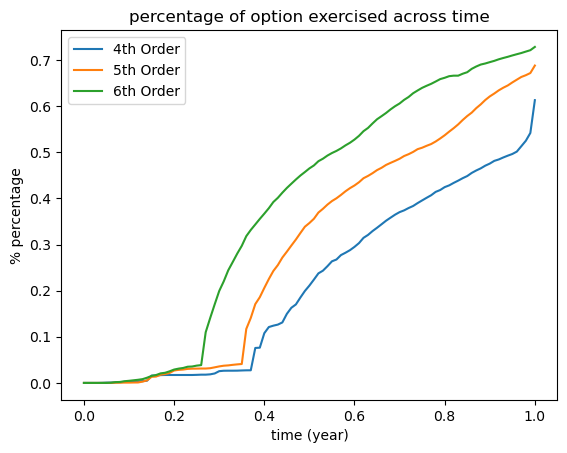

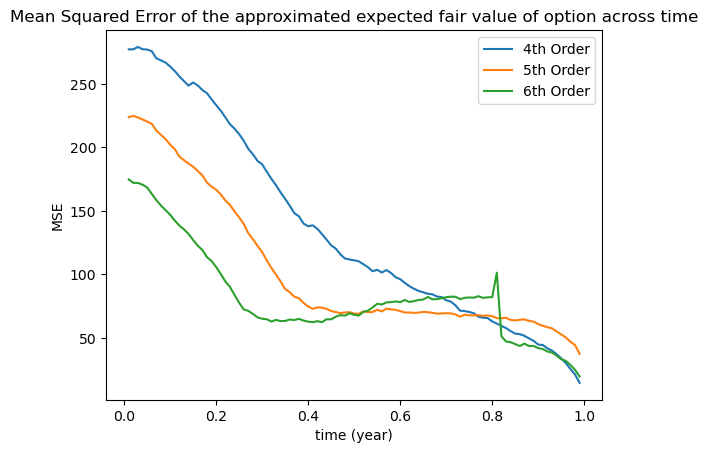

In [17]:
plt.figure(1)
plt.plot(times,option_value2.mean(1))
plt.plot(times,option_value4.mean(1))
plt.plot(times,option_value5.mean(1))

plt.legend(["4th Order", "5th Order" , "6th Order"])
plt.title("option values accross time")
plt.xlabel("time (year) ")
plt.ylabel("price")

plt.figure(2)
plt.plot(times,exercise2.sum(1).cumsum()/n)
plt.plot(times,exercise4.sum(1).cumsum()/n)
plt.plot(times,exercise5.sum(1).cumsum()/n)

plt.title("percentage of option exercised across time")
plt.xlabel("time (year)")
plt.ylabel("% percentage")
plt.legend(["4th Order", "5th Order" , "6th Order"])

plt.figure(3)
plt.plot(times,mse2)
plt.plot(times,mse4)
plt.plot(times,mse5)

plt.legend(["0","0.5","1","5"])
plt.title("Mean Squared Error of the approximated expected fair value of option across time")
plt.xlabel("time (year)")
plt.ylabel("MSE")
plt.legend(["4th Order", "5th Order" , "6th Order"])


perhaps much more prominately the choice of Lagurre Polynomials have a much much more significant impact. 

Here we attempt to implement a K fold cross validation scheme to help us select our hyperprameters. 

Inital results under this approach shows that under the AIC criterion, 4th order is as well as lambda = 0 is prefered as consistent with our results. However without good benchmarks, especially for more exotic options, this is not conclusive and requies much further investigation 

In [18]:
mse, mape , vdiff = american_lsm.Kfold_cv_train(2,K,rf)

100%|██████████| 5/5 [03:20<00:00, 40.14s/it]


In [19]:
Lhat = mse.sum(1)
# alpha + 1 basis functions + lambda 
k = np.array([6,7,8])
AIC = 2*k - 2*np.log(Lhat)
print("AIC under ")
print(AIC)

print()
print(mse.sum(0))

4    0.306304
5    2.832653
6    5.306996
dtype: float64
0.00    162.792318
0.05    163.192349
0.50    165.435567
1.00    164.895128
5.00    165.746197
dtype: object
